# AMS 526 Homework 6
**submitted by Jiaxi Zhao on 2nd Dec, 2020**

In this experiment, we implement the conjugate gradient (CG) method and the preconditioned conjugate gradient (PCG)
method with the Jacobi preconditioner for solving SPD linear systems. We compare their performance in terms of rate of convergence and accuracy.

In [173]:
import math
import numpy as np
import numpy.random as r
import scipy.linalg as alg
import scipy.sparse as spa
from matplotlib import pyplot as plt 
from time import time
from scipy.linalg import lu as lu
from scipy.linalg import solve_triangular as st
from scipy.linalg import solve as ss
from scipy.sparse.linalg import spsolve as sps

## Overview of the method to solve a linear system
### Implementation of the CG method
In this section, we briefly review the CG method.

The CG method aims to solve the linear system $Ax = b$ with $A \in \mathbb{R}^{n \times n}$ SPD. It solve this by viewing it as the first order condition of a quadratic programming, i.e.
\begin{equation}
    \min_x \frac{1}{2} x^T A x - b^T x.
\end{equation}
The iteration is given below
\begin{itemize}
    \item Set $x_0 = 0, r_0 = p_0 = b$.
    \item Repeated the following procedure until converges.
    \item $\alpha_k = \frac{r_{k - 1}^T r_{k - 1}}{p_{k - 1}^T A p_{k - 1}}$.
    \item $x_k = x_{k - 1} + \alpha_k p_{k - 1}$.
    \item $r_k = r_{k - 1} - \alpha_k A p_{k - 1}$.
    \item $\beta_k = \frac{r_{k}^T r_{k}}{r_{k - 1}^T r_{k - 1}}$.
    \item $p_k = r_{k} + \beta_k p_{k - 1}$.
\end{itemize}
Notice CG is intrinsically connected with Krylov subspace method. We also implement the CG method with Jacobi precondtioner, given by
\begin{itemize}
    \item Set $x_0 = 0, r_0 = b, M = diag(A), z_0 = p_0 = M^{-1}b$.
    \item Repeated the following procedure until converges.
    \item $\alpha_k = \frac{r_{k - 1}^T z_{k - 1}}{p_{k - 1}^T A p_{k - 1}}$.
    \item $x_k = x_{k - 1} + \alpha_k p_{k - 1}$.
    \item $r_k = r_{k - 1} - \alpha_k A p_{k - 1}$.
    \item $z_k = M^{-1} r_k$.
    \item $\beta_k = \frac{r_{k}^T z_{k}}{r_{k - 1}^T z_{k - 1}}$.
    \item $p_k = z_{k} + \beta_k p_{k - 1}$.
\end{itemize}
Notice that the pseudocode in the lecture is wrong.

In [168]:
tol = 1E-14
def sgn(x):
    # Modified sign function
    if x == 0:
        return 1
    else:
        return np.sign(x)

def CG(A, b):
    # CG method
    n   = A.shape[0]
    x   = np.zeros([n, 1])
    r   = b.copy()
    p   = b.copy()
    for k in range(n):
        alpha = (r.T @ r) / (p.T.dot(A.dot(p)))
        x     = x + alpha * p
        temp  = r.T @ r
        r     = r - alpha * A.dot(p)
        beta  = (r.T @ r) / temp
        p     = r + beta * p
        if alg.norm(p, 2) < tol:
            break
        
    return x

def PCG(A, b):
    # CG method with Jacobi preconditioner
    n   = A.shape[0]
    x   = 0
    r   = b.copy()
    M   = 1 / A.diagonal().reshape(n, 1).copy()
    p   = M * r
    z   = p
    for k in range(n):
        alpha = (r.T @ z) / (p.T.dot(A.dot(p)))
        x     = x + alpha * p
        temp  = r.T @ z
        r     = r - alpha * A.dot(p)
        z     = M * r
        beta  = (r.T @ z) / temp
        p     = z + beta * p
        if alg.norm(p, 2) < tol:
            break
        
    return x

In [169]:
A   = r.randn(5, 5)
A   = A.T @ A
#A   = np.eye(5)
b   = r.randn(5, 1)
print(CG(A, b))
print(PCG(A, b))
print(ss(A, b))

[[-0.55353114]
 [-1.52798508]
 [ 1.55929146]
 [-0.74122267]
 [-0.41973035]]
[[-0.55353114]
 [-1.52798508]
 [ 1.55929146]
 [-0.74122267]
 [-0.41973035]]
[[-0.55353114]
 [-1.52798508]
 [ 1.55929146]
 [-0.74122267]
 [-0.41973035]]


## Numerical experiment on FDM for second order elliptic PDE
In this section, we test our algorithm under the following linear system
\begin{equation}
    (4 + h^2)x_{ij} - x_{i - 1, j} - x_{i + 1, j} - x_{i, j - 1} - x_{i, j + 1} = h^2, x \in \mathbb{R}^{n^2}.
\end{equation}
This is exactly the FEM for solving the following second order linear elliptic PDE
\begin{equation*}
    \left\{\begin{aligned}
        u - \Delta u & = 1, \quad x \in \Omega = (0, 1) \times (0, 1),     \\
        u & = 0, \quad x \in \partial \Omega.
    \end{aligned}\right.
\end{equation*}
We solve this linear system using CG and CG with Jacobi preconditioner. First, we construct the discretization of the differential operator as follows.

Meanwhile, since the Laplacian matrix is sparse, in the following experiments, we will test the performance of both sparse and non-sparse version of out algorithms.

In [175]:
def init(n, sparse = 'n'):
    # initialize function for discrete Laplacian matrix A and vector b
    h   = 1 / (1 + n)
    A1  = np.eye(n) * 2
    for i in range(1, n - 1):
        A1[i, i - 1] = -1
        A1[i, i + 1] = -1
    A1[0, 1] = -1
    A1[n - 1, n - 2] = -1
    A  = np.kron(A1, np.eye(n)) + np.kron(np.eye(n), A1) + np.eye(n * n) * h * h
    b  = np.ones([n * n, 1]) * h * h
    if sparse == 's':
        A   = spa.csc_matrix(A)
    return A, b

### Non-sparse version
We first test the non-sparse version of our algorithms.

In [177]:
n    = 64
A, b = init(n)
start = time()
x1   = CG(A, b)
print('Time consumption for CG:', time() - start)
start = time()
x2   = PCG(A, b)
print('Time consumption for PCG:', time() - start)
start = time()
x3   = ss(A, b)
print('Time consumption for alg.solve:', time() - start)
print(alg.norm(x1 - x3, 2))
print(alg.norm(x2 - x3, 2))

Time consumption for CG: 2.341099739074707
Time consumption for PCG: 2.268588066101074
Time consumption for alg.solve: 0.6868631839752197
4.4255342880268665e-14
3.769831526251942e-14


n =  8
2.2180052528553994e-16
3.513403938818726e-16
n =  16
1.8542796309083302e-15
1.0935098435553744e-14
n =  32
3.708113413284106e-15
8.483628052887828e-15
n =  64
4.4255342880268665e-14
3.769831526251942e-14
1.9563088817661571
1.9590099513858459
2.226194165493936


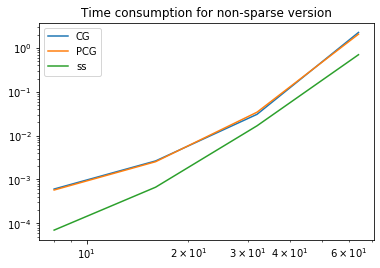

In [178]:
time_record = np.zeros([4, 3])
for i in range(3, 7):
    n    = pow(2, i)
    print("n = ", n)
    A, b = init(n)
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x1   = CG(A, b)
    time_record[i - 3, 0] = (time() - start) / pow(2, pow(2, 6) / n)
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x2   = PCG(A, b)
    time_record[i - 3, 1] = (time() - start) / pow(2, pow(2, 6) / n)
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x3   = ss(A, b)
    time_record[i - 3, 2] = (time() - start) / pow(2, pow(2, 6) / n)
    print(alg.norm(x1 - x3, 2))
    print(alg.norm(x2 - x3, 2))
    
mylabel = ['CG', 'PCG', 'ss']
for i in range(3):
    plt.plot(pow(2, np.linspace(3, 6, 4)), time_record[:, i], label = mylabel[i])
    x       = np.linspace(3, 6, 4) * 2
    A       = np.vstack([x, np.ones(len(x))]).T
    m1, c   = np.linalg.lstsq(A, np.log2(time_record[:, i]), rcond = -1)[0]
    print(m1)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.title('Time consumption for non-sparse version')
plt.show()

\begin{remark}
    The above figure illustrates the efficiency of CG and PCG we implemented. It can be seen that our implemented CG performs pretty well compare to the inline function in scipy. While PCG and CG do not have much difference, indicating that Jacobi preconditioner is usually not efficient although easy to implement. Meanwhile, we can see that the scale of the time consumption is quadratic instead of cubic on the size of the problem, indicating that CG stops after relatively small number of iterations comparing with $n$, this may be partially explained by the structure of Laplacian, with clustered eigenvalues.
\end{remark}

### Sparse version
We next test the sparse version of our algorithms.

In [179]:
n    = 64
A, b = init(n, 's')
start = time()
x1   = CG(A, b)
print('Time consumption for CG:', time() - start)
start = time()
x2   = PCG(A, b)
print('Time consumption for PCG:', time() - start)
start = time()
x3   = sps(A, b)
print('Time consumption for alg.solve:', time() - start)
print(alg.norm(x1 - x3, 2))
print(alg.norm(x2 - x3, 2))

Time consumption for CG: 0.031343698501586914
Time consumption for PCG: 0.02451491355895996
Time consumption for alg.solve: 0.012029170989990234
81.67759381239473
81.67759381239479


n =  8
1.014703176517914
1.014703176517914
n =  16
4.66577763576505
4.665777635765048
n =  32
19.84502781002836
19.845027810028324
n =  64
81.67759381239473
81.67759381239479
0.8157739918450359
0.7884472552945845
1.1294000987271609


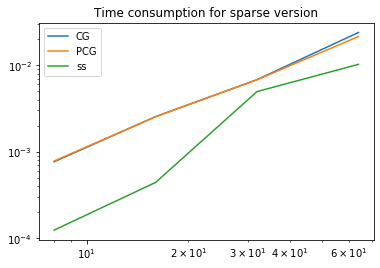

In [181]:
time_record = np.zeros([4, 3])
for i in range(3, 7):
    n    = pow(2, i)
    print("n = ", n)
    A, b = init(n, 's')
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x1   = CG(A, b)
    time_record[i - 3, 0] = (time() - start) / pow(2, pow(2, 6) / n)
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x2   = PCG(A, b)
    time_record[i - 3, 1] = (time() - start) / pow(2, pow(2, 6) / n)
    start = time()
    for j in range(pow(2, int(pow(2, 6) / n))):
        x3   = sps(A, b)
    time_record[i - 3, 2] = (time() - start) / pow(2, pow(2, 6) / n)
    print(alg.norm(x1 - x3, 2))
    print(alg.norm(x2 - x3, 2))
    
mylabel = ['CG', 'PCG', 'ss']
for i in range(3):
    plt.plot(pow(2, np.linspace(3, 6, 4)), time_record[:, i], label = mylabel[i])
    x       = np.linspace(3, 6, 4) * 2
    A       = np.vstack([x, np.ones(len(x))]).T
    m1, c   = np.linalg.lstsq(A, np.log2(time_record[:, i]), rcond = -1)[0]
    print(m1)
plt.semilogx()
plt.semilogy()
plt.legend()
plt.title('Time consumption for sparse version')
plt.show()

\begin{remark}
    Although the sparse of our implementations are close to inline implementatioin, it is weird that the result is not so accurate.
\end{remark}